### Imports and libraries

In [1]:
! pip install tiktoken sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [3]:
import pandas as pd
from fixed_token_chunker_modified import FixedTokenChunker
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Dataset overview

We open the datasets and see how they're organised:

In [4]:
questions_df = pd.read_csv('questions_df.csv')

In [5]:
questions_df[questions_df['corpus_id'] == 'wikitexts'].head()['references']

,references
76,"[{""content"": "" Valkyria Chronicles 3 was adapt..."
77,"[{""content"": ""Perhaps because Abraham Lincoln ..."
78,"[{""content"": ""Unlike its two predecessors , Va..."
79,"[{""content"": ""On January 28 , then Governor He..."
80,"[{""content"": ""Inside the Little Rock Arsenal a..."


In [14]:
with open('wikitexts.md') as f:
  corpus = f.read()

corpus[:800]

' = Valkyria Chronicles III = \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n The game began development in 2010 , carrying over a large portion of t'

In [7]:
questions_reference = questions_df[questions_df['corpus_id'] == 'wikitexts'].head()[['question', 'references']]

In [8]:
veval = np.vectorize(eval)

questions_reference['references'] = veval(questions_reference['references'].to_numpy()) # change str to dict

In [9]:
for _, row in questions_reference.iterrows():
  print(row['references'][0]['content']) # best found info example

 Valkyria Chronicles 3 was adapted into a two @-@ episode original video animation series in the same year of its release 
Perhaps because Abraham Lincoln had not yet been inaugurated as President , Captain Totten received no instructions from his superiors and was forced to withdraw his troops 
Unlike its two predecessors , Valkyria Chronicles III was not released in the west 
On January 28 , then Governor Henry Massey Rector informed Captain Totten that he and his soldiers would be " permitted to remain in the possession of the Federal officers until the State , by authority of the people , shall have determined to sever their connection with the General Government , " Totten responded to this by telling the Governor that his orders came from the United States Government and began a desperate but ultimately futile dispatch of letters and telegrams asking for reinforcements , although rumors were widely spread that they were already coming 
Inside the Little Rock Arsenal after its sei

In [10]:
questions = questions_reference['question'].to_list()

Since we're just chunking, no data preparation is required on this step.

### Chunking

We select FixedToken chunker with some parameters:

In [11]:
chunker = FixedTokenChunker(chunk_size=800, chunk_overlap=400, encoding_name="cl100k_base")

You see that I've imported  `fixed_token_chunker_modified`, not just `fixed_token_chunker`. The reason is that I've changed the `split_text` method, now it returns start and end indices for all the chunks, which is useful for the metrics calculation.

In [139]:
chunks, indices = chunker.split_text(corpus)

### Vectorizing

Now we have to map the token sequences to the vector space. I use all-MiniLM-L6-v2 to do so.

In [12]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [145]:
questions_embeddings = model.encode(questions)
print(questions_embeddings.shape)

(5, 384)


In [146]:
chunks_embeddings = model.encode(chunks)
print(chunks_embeddings.shape)

(66, 384)


### Retrieval

Here I use cosine similarity to select closest chunks for each of the questions.

In [147]:
similarity = cosine_similarity(questions_embeddings, chunks_embeddings) # similarity computation

In [148]:
similarity.shape # num_question x num_chunks

(5, 66)

In [209]:
num_retrieved = 8 # experimental number, will be used later to estimate the parameters of the experiments

In [210]:
anss = (-similarity).argsort(axis=1)[:, :num_retrieved] # minus similarity because the sorting is ascending

In [327]:
print(questions[2]) # example question

Why wasn't Valkyria Chronicles III released in the West?


In [212]:
np.array(chunks)[anss][2][0] # example of a relevant chunk for a given question

np.str_(' demo was made available for journalists and attendees . During the publicity , story details were kept scant so as not to spoil too much for potential players , along with some of its content still being in flux at the time of its reveal . To promote the game and detail the story leading into the game \'s events , an episodic Flash visual novel written by Fujii began release in January 2011 . The game was released January 27 , 2011 . During an interview , the development team said that the game had the capacity for downloadable content ( DLC ) , but that no plans were finalized . Multiple DLC maps , featuring additional missions and recruitable characters , were released between February and April 2011 . An expanded edition of the game , Valkyria Chronicles III Extra Edition , released on November 23 , 2011 . Packaged and sold at a lower price than the original , Extra Edition game with seven additional episodes : three new , three chosen by staff from the game \'s DLC , and 

### Metrics

Precision and recall calculation:

In [215]:
def range_len(ranges):
  return sum([end_ - start_ for (start_, end_) in ranges])

def intersect(range1, range2):
  start_id = max(range1[0], range2[0])
  end_id = min(range1[1], range2[1])

  if start_id <= end_id:
    return (start_id, end_id)
  else:
    return None

def unite(ranges):
  if ranges == []:
    return None

  ranges = sorted(ranges, key=lambda x: x[0])
  ans = [ranges[0]]

  for current_ in ranges[1:]:
    if ans[-1][1] >= current_[0]:
      ans[-1] = (ans[-1][0], max(ans[-1][1], current_[1]))
    else:
      ans.append(current_)

  return ans


def prec_recall_(relevant_indices, golden_indices):
  questions_number = len(relevant_indices)
  for question_index in range(questions_number): # iterate over questions
    intersection_sections = []

    for chunk in relevant_indices[question_index]:
      for exc in golden_indices[question_index]:
        intersection = intersect(chunk, exc)

        if not isinstance(intersection, type(None)):
          intersection_sections.append(intersection)

    intersection = unite(intersection_sections)

    if isinstance(intersection, type(None)):
      len_intersection = 0
    else:
      len_intersection = range_len(intersection)

    precision = len_intersection / range_len(relevant_indices[question_index])
    recall = len_intersection / range_len(golden_indices[question_index])

  return precision, recall


I select golden excerpts from the dataset:

In [216]:
def get_golden_indices(questions_reference):
  golden_indices = []

  for _, row in questions_reference.iterrows():
    start_indices = [x['start_index'] for x in row['references']]
    end_indices = [x['end_index'] for x in row['references']]
    ranges = list(zip(start_indices, end_indices))
    golden_indices.append(ranges)

  return golden_indices

I select start and end indices for the closest chunks found:

In [217]:
relevant_indices = np.array(indices)[anss]

relevant_indices.shape

(5, 8, 2)

In [218]:
golden_indices = get_golden_indices(questions_reference)

Finally, the metrics are computed:

In [219]:
prec_recall_(relevant_indices, golden_indices)

(np.float64(0.008225499047045842), 1.0)

### Evaluation pipeline

Here I combine all the code above into one evaluation function:

In [136]:
def evaluate_chunker(corpus, questions_reference, chunker, emb_function, num_retrieved):
  questions = questions_reference['question'].to_list()
  chunks, indices = chunker.split_text(corpus)

  questions_embeddings = emb_function(questions)
  chunks_embeddings = emb_function(chunks)

  similarity = cosine_similarity(questions_embeddings, chunks_embeddings)
  sorted_chunk_indices = (-similarity).argsort(axis=1)[:, :num_retrieved]

  relevant_indices = np.array(indices)[sorted_chunk_indices]

  golden_indices = get_golden_indices(questions_reference)

  precision, recall = prec_recall_(relevant_indices, golden_indices)

  return precision, recall



### Experiments

The authors in the paper use chunks of size 250 for the chosen model. I compare these results with the chunks of size 125 and 500.

As a rule of thumb they set the chunks overlap length to a half of a chunk. We'll see what happens if this number is decreased to a quarter of a chunk length or if it's zeroed.

We've found out that 8 retrieved chunks allows us to get 1.0 recall, meaning we were able to get all the valuable information out of the corpora. I'll set this value as a maximum for the $\text{num_retrieved}$ parameter and will cover values 3, 5 and 8 in my experiments.

In [257]:
chunk_sizes = [125, 250, 500]
chunk_parts = [0.5, 0.25, 0]
num_retrieved_ = [3, 5, 8]

In [258]:
results = {"precision": {}, "recall": {}}
prec_array = np.zeros((len(chunk_sizes), len(chunk_parts), len(num_retrieved_)))
rec_array = np.copy(prec_array)

for chunk_id, chunk_size in enumerate(chunk_sizes):
  for part_id, chunk_part in enumerate(chunk_parts):
    for retrieved_id, num_retrieved in enumerate(num_retrieved_):
      overlap = int(chunk_part * chunk_size)
      exp_name = f"Size_{chunk_size}_Overlap_{overlap}_Retrieved_{num_retrieved}"

      chunker = FixedTokenChunker(chunk_size=chunk_size, chunk_overlap=int(chunk_part * chunk_size), encoding_name="cl100k_base")
      prec_, rec_ = evaluate_chunker(corpus, questions_reference, chunker, model.encode, num_retrieved)
      prec_array[chunk_id, part_id, retrieved_id] = prec_ * 100
      rec_array[chunk_id, part_id, retrieved_id] = rec_ * 100

      results['precision'][exp_name] = "{:.2f}".format(prec_ * 100) # percents
      results['recall'][exp_name] = "{:.2f}".format(rec_ * 100)


In [260]:
df = pd.DataFrame(results)

In [261]:
df.to_csv('experiment_results.csv', index=False)

In [262]:
df

,precision,recall
Size_125_Overlap_62_Retrieved_3,13.70,100.00
Size_125_Overlap_62_Retrieved_5,8.41,100.00
Size_125_Overlap_62_Retrieved_8,5.13,100.00
Size_125_Overlap_31_Retrieved_3,14.03,100.00
Size_125_Overlap_31_Retrieved_5,8.59,100.00
Size_125_Overlap_31_Retrieved_8,5.50,100.00
Size_125_Overlap_0_Retrieved_3,8.23,58.13
Size_125_Overlap_0_Retrieved_5,5.07,58.13
Size_125_Overlap_0_Retrieved_8,3.11,58.13
Size_250_Overlap_125_Retrieved_3,7.21,100.00


### Conclusions

Let's visualize our results. First of all, I compare precision for fixed $\text{num_retrieved}$ for different chunk lengths and overlaps:

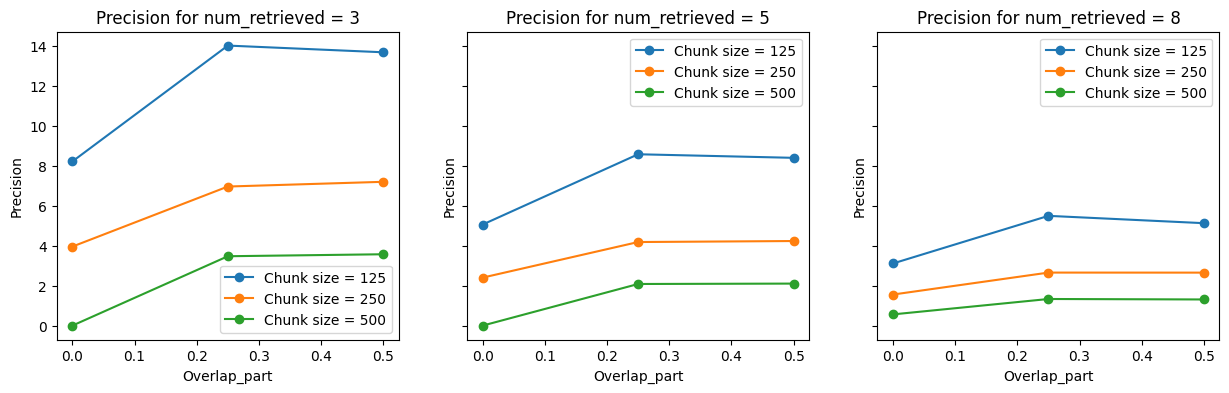

In [316]:
fig, ax = plt.subplots(1,  3, figsize=(15, 4), sharey='row')

for retrieved_id, num_retrieved in enumerate(num_retrieved_):

  selected_prec = prec_array[:, :, retrieved_id]

  for size_id, prec_data in enumerate(selected_prec):
    ax[retrieved_id].plot(chunk_parts, prec_data, "-o", label = f'Chunk size = {chunk_sizes[size_id]}')
    ax[retrieved_id].legend()

  ax[retrieved_id].set_title(f'Precision for num_retrieved = {num_retrieved}')
  ax[retrieved_id].set_xlabel("Overlap_part")
  ax[retrieved_id].set_ylabel("Precision")


We see that the overlapping presence improves the presicion, but there is no significant difference between a quarter and a half. The precision slightly decreases with the growth of the overlap. It is also obvious that the precision dramatically decreases with the growth of the $\text{num_retrieved}$ parameter.

Another conclusion is that the precision is higher when the chunk size decreases. Since the relevant information size is pretty small it is to be expected, because we are likely to get the info in a small number of tokens, others will be irrelelevant.

Then we compare recall with the same hyperparameter fixed:

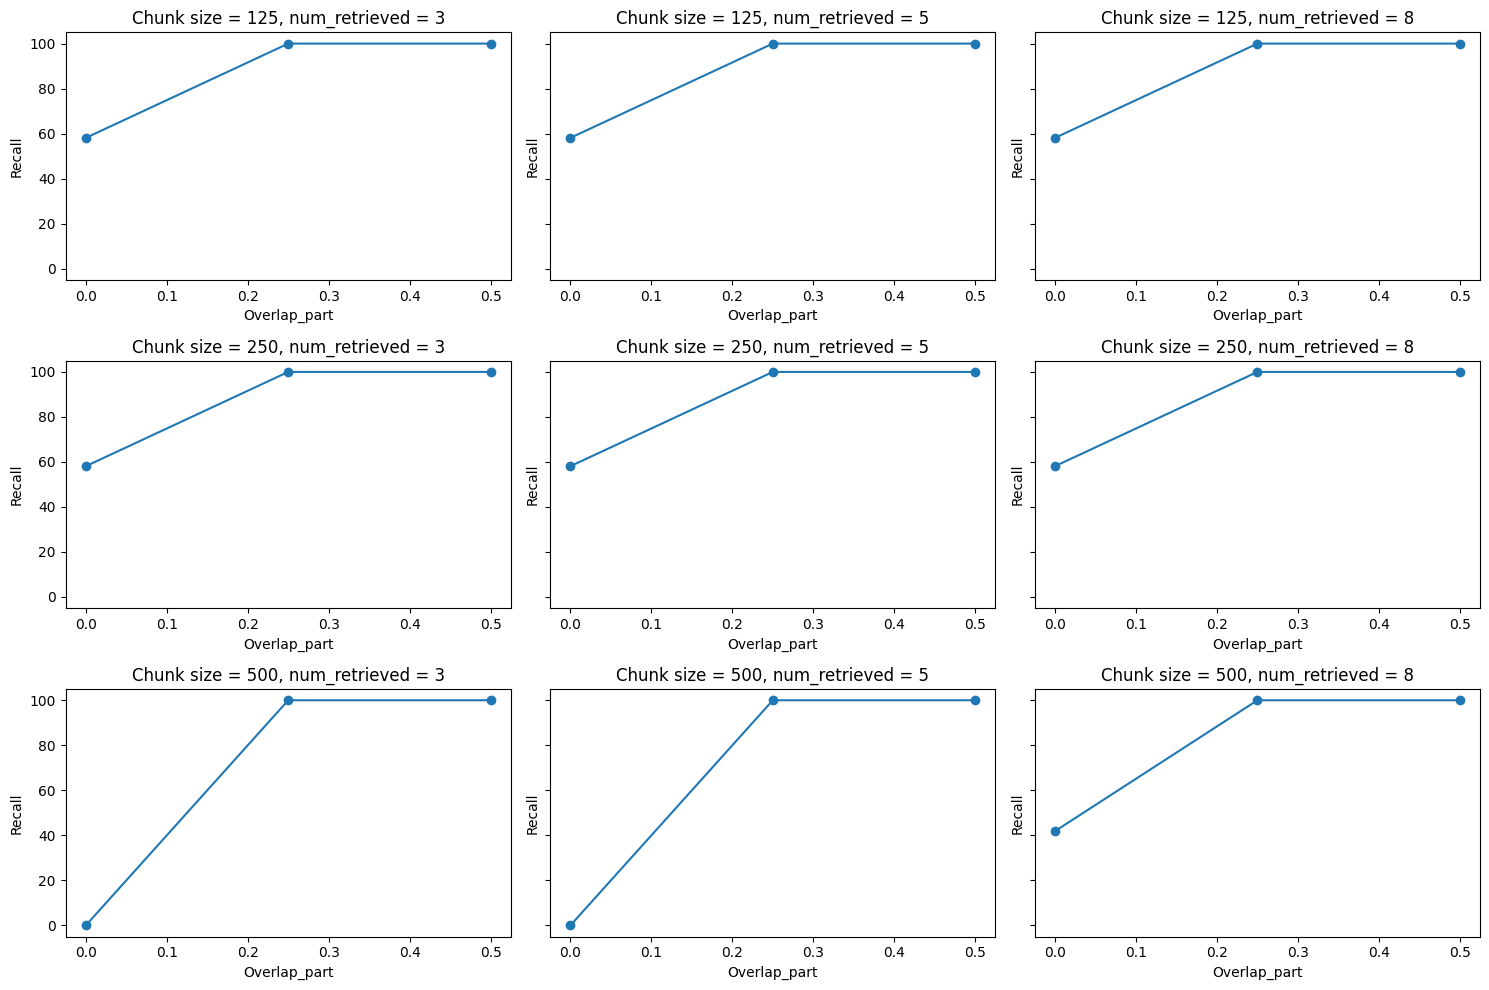

In [326]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharey=True)

for retrieved_id, num_retrieved in enumerate(num_retrieved_):

  selected_rec = rec_array[:, :, retrieved_id]


  for size_id, rec_data in enumerate(selected_rec):
    ax[size_id, retrieved_id].plot(chunk_parts, rec_data, "-o")
    ax[size_id, retrieved_id].set_title(f'Chunk size = {chunk_sizes[size_id]}, num_retrieved = {num_retrieved}')

    ax[size_id, retrieved_id].set_xlabel("Overlap_part")
    ax[size_id, retrieved_id].set_ylabel("Recall")

fig.tight_layout()
plt.show()

This time the diagrams overlay, so I had to split them into three different graphs for each of the $\text{num_retrieved}$ parameter value.

We see the growth in the recall metric if the overlay is present, but there is no difference between an overlay of a quarter and an overlay of a half. This means that for FixedToken chunker it may be better to fix $\text{chunk_part}$ value to a quarter, because it will decrease the number of chunks and will not lead to a decline in recall.

In terms of recall there are no difference between $\text{chunk_size}$ of 125 and 250, while a chunk of 500 tokens performs worse without any overlap.

Overall, the model with $\text{chunk_size} = 125, \text{num_retrieved} = 3, \text{overlap_part} = 0{,}25$ performs the best. The only downside of that is that we have to encode more chunks, which leads to a longer processing time.